# EDA and Data Modelling

## Introduction



The cleaned csv files from Data Cleaning notebook are used in this notebook.This notebook will include: 

* Exploratory analysis of data 
* Building multiple models to classify whether the tweets describe a disaster or not
* The result from multiple model will be compared to find the best model.


## Importing libraries

In [81]:
# Importing required libraries

import os              # To interact with OS(get directory info)
import pandas as pd    # For data manipulation
import matplotlib.pyplot as plt  # To plot ROC Curve
import numpy as np
import sklearn.metrics as metrics  # To calculate TPR, FPR, ROC-AUC and F score
from sklearn.model_selection import train_test_split # To split train and test data
from sklearn.feature_extraction.text import TfidfTransformer #To vectorize the text
from sklearn.feature_extraction.text import CountVectorizer #To vectorize the text
from sklearn.linear_model import LogisticRegression as LogReg #Logistic regression
from sklearn.tree import DecisionTreeClassifier   #Desicion tree classifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,           
                              GradientBoostingClassifier, ExtraTreesClassifier, )
from sklearn.linear_model import SGDClassifier   #SGD classifier for Linear SVM
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline            #for pipelining processes
from sklearn.metrics import f1_score  #To measure F1 score

## Reading cleaned CSV files 

In [82]:
df_train = pd.read_csv(os.path.join(os.path.dirname('.'), '../Data Cleaning/Clean_train_data.csv'), index_col = 0)
df_test = pd.read_csv(os.path.join(os.path.dirname('.'), '../Data Cleaning/Clean_test_data.csv'), index_col = 0)

In [83]:
 df_train

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident ask shelter place notify officer evac...,1
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1
4,7,NaN,NaN,get send photo ruby alaska smoke wildfire pour...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant crane hold bridge collapse nearby home,1
7609,10870,NaN,NaN,control wild fire california even northern par...,1
7610,10871,NaN,NaN,volcano hawaii,1
7611,10872,NaN,NaN,police investigate ebike collide car little po...,1


## Exploratory Data Analysis

* Exploring the affect of 'location' and 'target' columns on the target variable

In [84]:
location_df = df_train.groupby(["location", "target"], as_index=False ).count()
location_df = location_df.drop(['id', 'keyword'], axis=1)
location_df.rename(columns={'text':'count'}, inplace=True)
location_df = location_df.pivot(index='location',columns='target')['count'].reset_index()
location_df.columns.name = None
location_df.rename(columns={0:'No Disaster',1:'Disaster'}, inplace=True)
location_df.sort_values(by=['Disaster'],ascending=False).sample(30)



,location,No Disaster,Disaster
1444,rio,1.0,NaN
875,karachi,NaN,4.0
1180,nh,1.0,3.0
709,hollywoodland,1.0,NaN
1706,the barn,1.0,NaN
2038,åålos mina cityã¢,1.0,NaN
1633,statesborovidalia,1.0,NaN
1196,nordrheinwestfalen,NaN,1.0
300,ca,79.0,51.0
136,arthas us,1.0,NaN


The location column in the data is very vague. While some values correspond to geographical places, some of the values are random texts for example: on sofa, on the go etc. Including this column in the model will make the model biased to the training set.Hence, 'location' column will not be used for modelling.

Still, for the purpose of exploration, let's see the locations with most number of disaster tweets

Text(0, 0.5, 'Location')

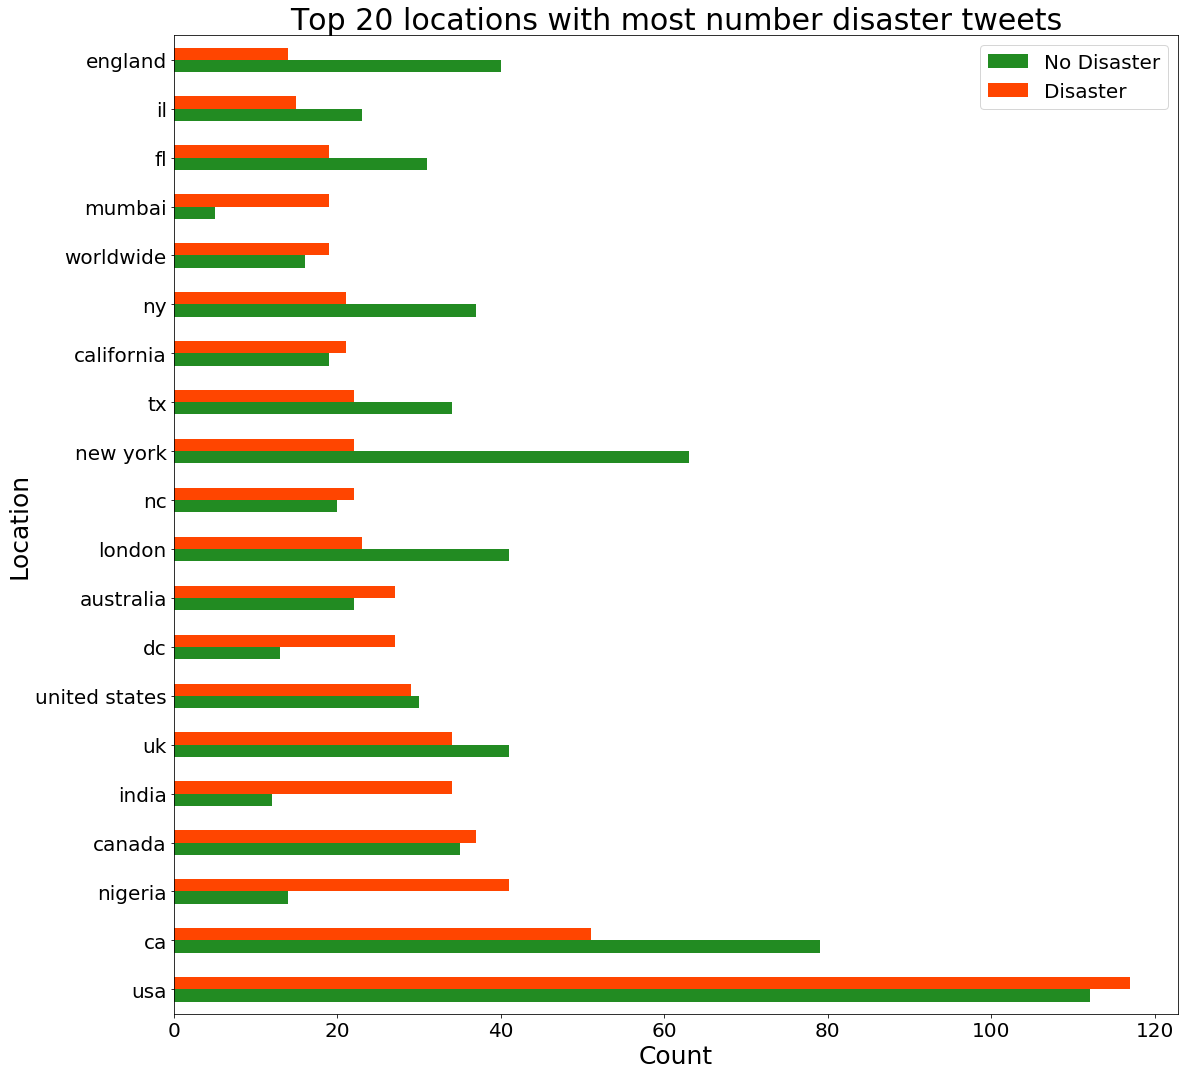

In [85]:
location_df.fillna(0,inplace=True)
l_disaster = location_df.sort_values(by=['Disaster'],ascending=False).head(20)
plot = l_disaster.plot(kind='barh', x= 'location' ,figsize=(18, 18),fontsize=20,color = ('forestgreen','orangered'))
plot.legend(loc=1, prop={'size': 20})
plot.set_title('Top 20 locations with most number disaster tweets', fontdict={'fontsize': 30})
plot.set_xlabel('Count', fontsize=25)
plot.set_ylabel('Location', fontsize=25)


Now, let's look at keyword column.

In [86]:
keyword_df = df_train.groupby(["keyword", "target"], as_index=False ).count()
keyword_df = keyword_df.drop(['id', 'location'], axis=1)
keyword_df.rename(columns={'text':'count'}, inplace=True)
keyword_df = keyword_df.pivot(index='keyword',columns='target')['count'].reset_index()
keyword_df.columns.name = None
keyword_df.rename(columns={0:'No Disaster',1:'Disaster'}, inplace=True)
keyword_df.fillna(0, inplace=True)
keyword_disaster = keyword_df.sort_values(by=['Disaster'],ascending = False).head(20)
keyword_disaster

,keyword,No Disaster,Disaster
94,flood,43.0,66.0
80,evacuate,19.0,57.0
12,attack,25.0,46.0
36,casualty,26.0,43.0
57,derail,30.0,43.0
105,hostage,26.0,42.0
95,forest fire,9.0,42.0
185,wreckage,0.0,39.0
58,derailment,0.0,39.0
128,outbreak,1.0,39.0


Text(0, 0.5, 'Keywords')

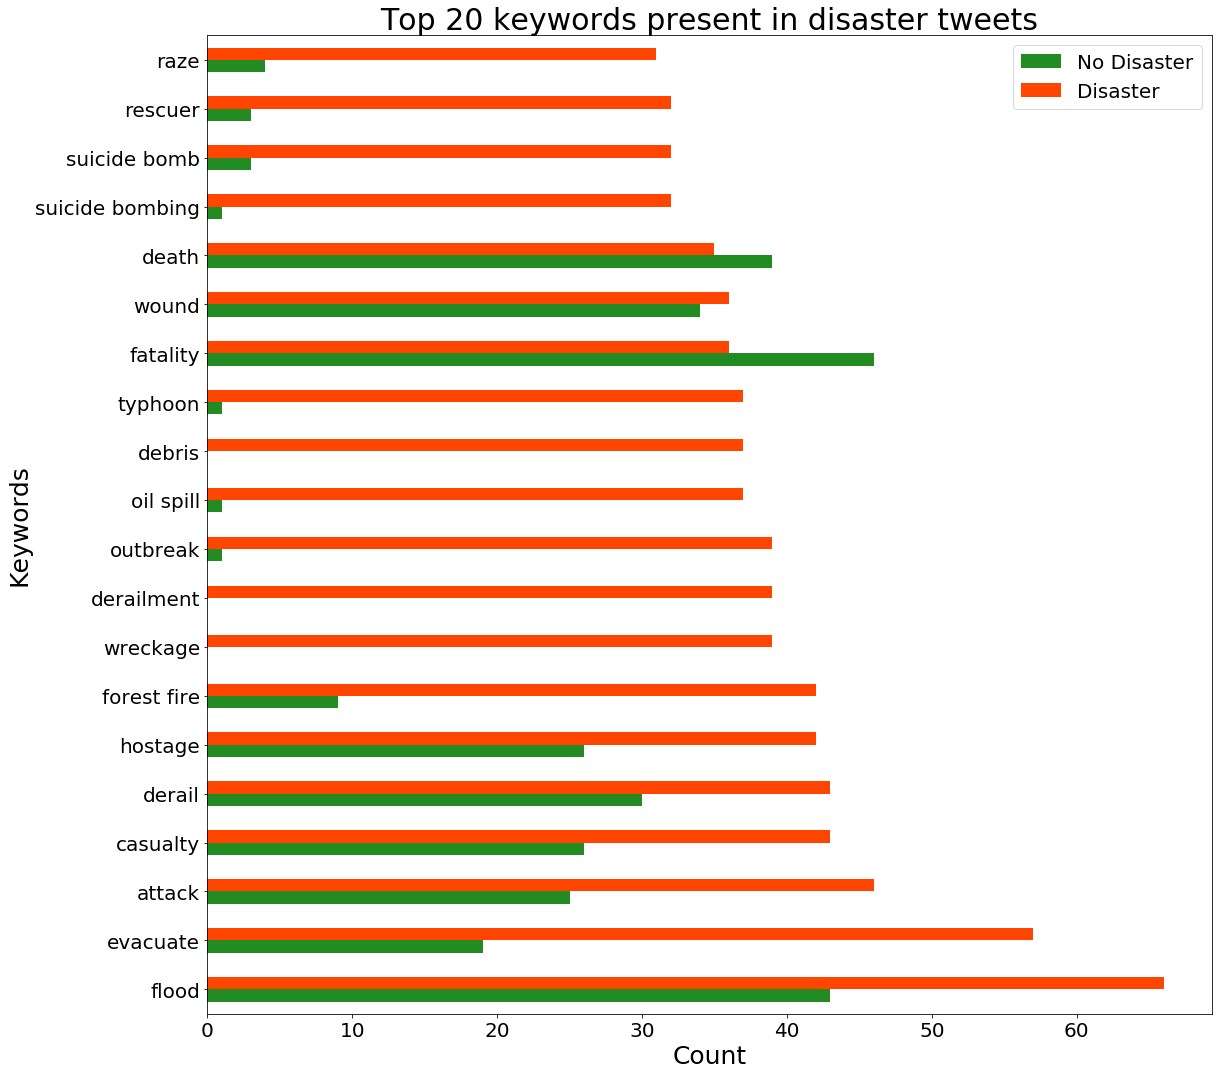

In [87]:
keyword_disaster = keyword_df.sort_values(by=['Disaster'],ascending = False).head(20)
plot = keyword_disaster.plot(kind='barh', x= 'keyword' ,figsize=(18, 18),fontsize=20,color = ('forestgreen','orangered'))
plot.legend(loc=1, prop={'size': 20})
plot.set_title('Top 20 keywords present in disaster tweets', fontdict={'fontsize': 30})
plot.set_xlabel('Count', fontsize=25)
plot.set_ylabel('Keywords', fontsize=25)

Text(0, 0.5, 'Keywords')

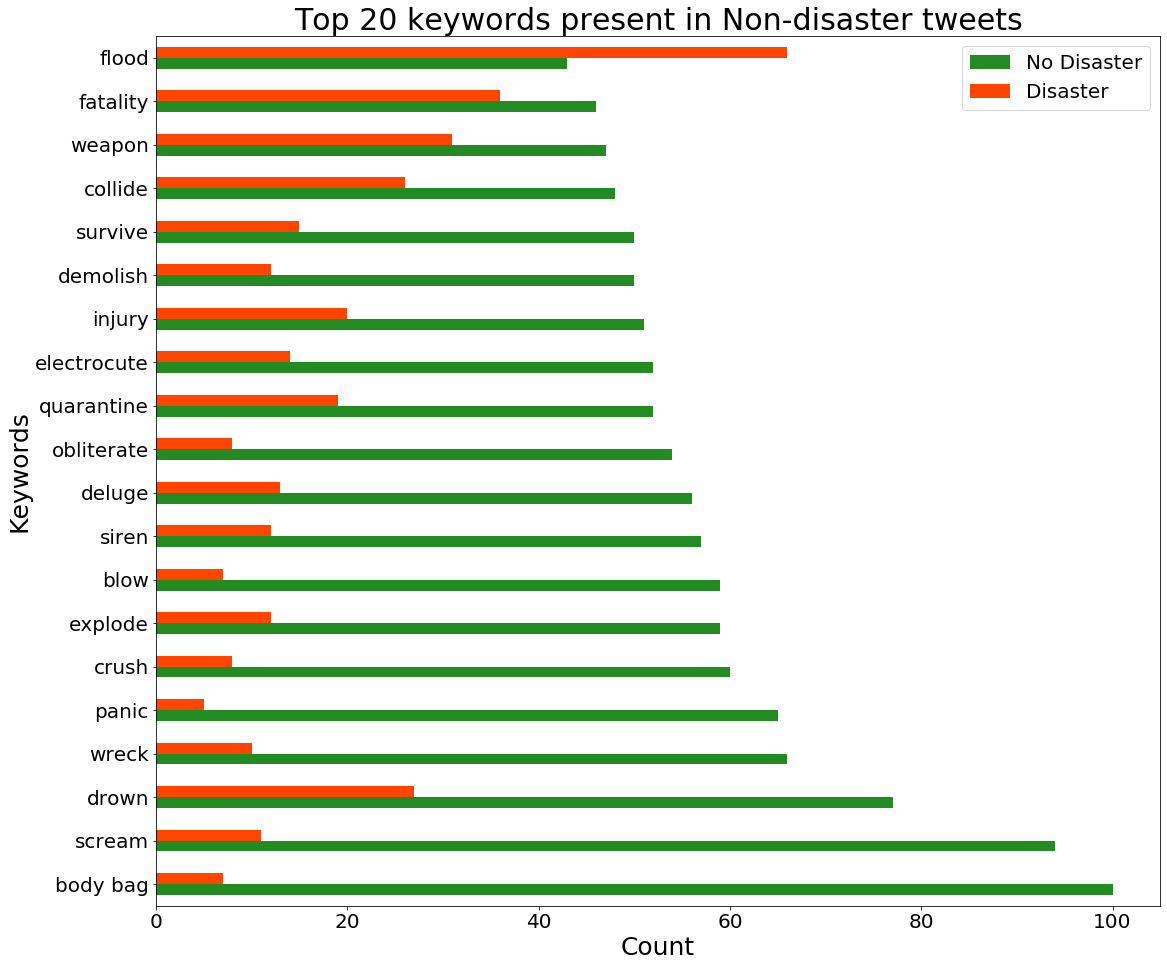

In [88]:
keyword_no = keyword_df.sort_values(by=['No Disaster'],ascending = False).head(20)
plot = keyword_no.plot(kind='barh', x= 'keyword' ,figsize=(18, 16),fontsize=20,color = ('forestgreen','orangered'))
plot.legend(loc=1, prop={'size': 20})
plot.set_title('Top 20 keywords present in Non-disaster tweets', fontdict={'fontsize': 30})
plot.set_xlabel('Count', fontsize=25)
plot.set_ylabel('Keywords', fontsize=25)

The following can be understood from the two graphs:
* Certain words that imply a disaster in common usage such as explode,electrocute etc are keywords to more non-disaster tweets.
* All tweets with wreckage as keywords are disasters tweets whereas wreck has more non-disaster tweets than non-disaster ones.
* All tweets with derailment as keywords are disasters tweets whereas derail also has more disaster tweet than non-disaster ones.

Adding keyword to the text

In [89]:
df_train = df_train.fillna(" ")
df_train["text"] = df_train["text"] + " " + df_train["keyword"].astype(str)

df_train.text.head(10)

0        deed reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2    resident ask shelter place notify officer evac...
3    people receive wildfire evacuation order calif...
4    get send photo ruby alaska smoke wildfire pour...
5    rockyfire update california hwy close directio...
6    flood disaster heavy rain cause flash flooding...
7                          im top hill see fire wood  
8    there emergency evacuation happen building acr...
9                        im afraid tornado come area  
Name: text, dtype: object

Splitting testing and training data


In [90]:
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['target'], test_size=0.3)

Method to calculate the Area under the ROC curve and F  score. Also, to plot the ROC curve.

In [91]:
def roc(pred_labels,modelname):
    
    fpr, tpr, threshold = metrics.roc_curve(y_test,pred_labels)
    auc = metrics.auc(fpr, tpr)
    f = f1_score(y_test, pred_labels)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.suptitle(modelname, fontsize=20)
    plt.show()
    return auc, f
  
    

Making a dataframe to hold the Area under the roc score and F score
from the models

In [92]:
model_result = pd.DataFrame(columns=['Model','AUC ROC','F1'])



### Logistic regression

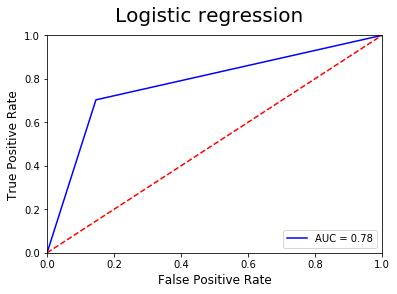

In [93]:

Log_regression = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                           ('tfidf', TfidfTransformer()), 
                           ('log', LogReg(solver='saga',penalty = 'l2'))])

Log_model = Log_regression.fit(X_train, y_train)

Log_prediction = Log_model.predict(X_test)
auc,f = roc(Log_prediction,'Logistic regression')

model_result = model_result.append({'Model':'Logistic regression','AUC ROC': auc,'F1':f}, ignore_index=True)


### Random Forest Classifier

/Users/shashanksharma/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


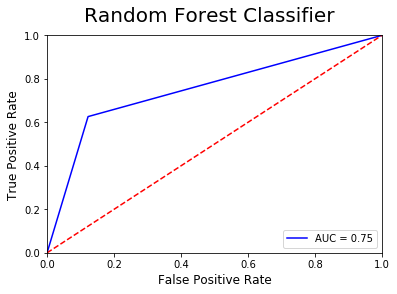

In [94]:
Random_forest = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                          ('tfidf', TfidfTransformer()), 
                          ('randomforest', RandomForestClassifier())])

RF_model = Random_forest.fit(X_train, y_train)

RF_prediction = RF_model.predict(X_test)
auc,f = roc(RF_prediction,'Random Forest Classifier')

model_result = model_result.append({'Model':'Random Forest Classifier','AUC ROC': auc,'F1':f}, ignore_index=True)

### ADA Boost Classifier

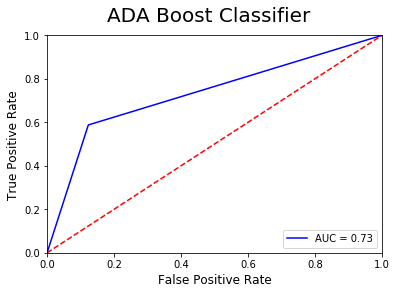

In [95]:
ada_classifier = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                          ('tfidf', TfidfTransformer()), 
                           ('Ada', AdaBoostClassifier())])

ada_model = ada_classifier.fit(X_train, y_train)

ada_prediction = ada_model.predict(X_test)
auc,f = roc(ada_prediction,'ADA Boost Classifier')

model_result = model_result.append({'Model':'ADA Boost Classifier','AUC ROC': auc,'F1':f}, ignore_index=True)

### Extra Trees Classifier

/Users/shashanksharma/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


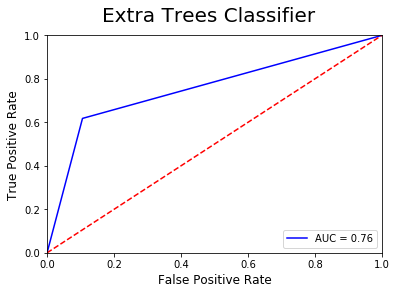

In [96]:
et_classifier = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                          ('tfidf', TfidfTransformer()), 
                          ('et', ExtraTreesClassifier())])

et_model = et_classifier.fit(X_train, y_train)

et_prediction = et_model.predict(X_test)
auc,f = roc(et_prediction,'Extra Trees Classifier')

model_result = model_result.append({'Model':'Extra Trees Classifier','AUC ROC': auc,'F1':f}, ignore_index=True)


### Gradient Boost classifier

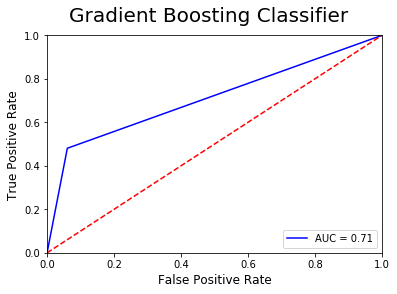

In [97]:
gb_classifier = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                          ('tfidf', TfidfTransformer()), 
                          ('gb', GradientBoostingClassifier())])

gb_model = gb_classifier.fit(X_train, y_train)

gb_prediction = gb_model.predict(X_test)
auc,f = roc(gb_prediction,'Gradient Boosting Classifier')

model_result = model_result.append({'Model':'Gradient Boosting Classifier','AUC ROC': auc,'F1':f}, ignore_index=True)

### Decision Tree Classifier

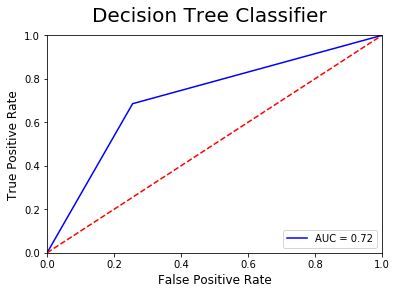

In [98]:
dt_classifier = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                          ('tfidf', TfidfTransformer()), 
                          ('dt', DecisionTreeClassifier())])

dt_model = dt_classifier.fit(X_train, y_train)

dt_prediction = dt_model.predict(X_test)
auc,f = roc(dt_prediction,'Decision Tree Classifier')

model_result = model_result.append({'Model':'Decision Tree Classifier','AUC ROC': auc,'F1':f}, ignore_index=True)



### SGD Classifier (SVM linear model)

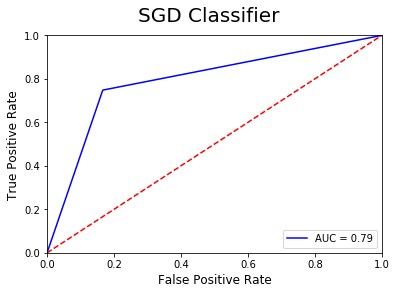

In [99]:
sgd_classifier = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                          ('tfidf', TfidfTransformer()), 
                           ('sgd', SGDClassifier(penalty='elasticnet'))])

sgd_model = sgd_classifier.fit(X_train, y_train)

sgd_prediction = sgd_model.predict(X_test)
auc,f = roc(sgd_prediction,'SGD Classifier')

model_result = model_result.append({'Model':'SGD Classifier','AUC ROC': auc,'F1':f}, ignore_index=True)




In [100]:
model_result

,Model,AUC ROC,F1
0,Logistic regression,0.778777,0.738798
1,Random Forest Classifier,0.751991,0.697971
2,ADA Boost Classifier,0.732362,0.669035
3,Extra Trees Classifier,0.756143,0.700885
4,Gradient Boosting Classifier,0.710140,0.614770
5,Decision Tree Classifier,0.715132,0.673136
6,SGD Classifier,0.790945,0.756842


Grid Search Cross Validation

In [101]:
# SGD classifier

grid_param = {
    'sgd__loss': ['hinge','squared_hinge'],
    'sgd__penalty': ['l2', 'elasticnet'],
    'sgd__learning_rate': ['optimal', 'adaptive'],
    'sgd__eta0':[1e-1,1e-2,1e-3,1e-4,1e-5]
}

grid_sgd = GridSearchCV(estimator=sgd_classifier,
                     param_grid=grid_param,
                     cv=5,
                     n_jobs=-1)

grid_model_sgd = grid_sgd.fit(X_train, y_train)

print(grid_model_sgd.best_params_) 


{'sgd__eta0': 0.001, 'sgd__learning_rate': 'adaptive', 'sgd__loss': 'squared_hinge', 'sgd__penalty': 'l2'}


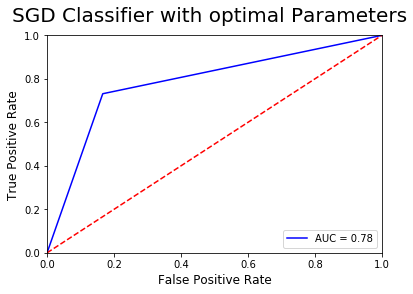

In [102]:
grid_sgd_prediction = grid_model_sgd.predict(X_test)
auc,f = roc(grid_sgd_prediction,'SGD Classifier with optimal Parameters')

model_result = model_result.append({'Model':'Grid_SGD Classifier','AUC ROC': auc,'F1':f}, ignore_index=True)

In [106]:
# logistic classifier

grid_param = {
    'log__penalty': ['l2', 'elasticnet'],
    'log__tol':[1e-1,1e-2,1e-3,1e-4,1e-5],
    'log__l1_ratio':[0.1,0.2,0.3,0.4],
    'log__C':[1,0.1,0.01]
}

grid_log = GridSearchCV(estimator=Log_regression,
                     param_grid=grid_param,
                     cv=5,
                     n_jobs=-1)

grid_model_log = grid_log.fit(X_train, y_train)

print(grid_model_log.best_params_) 

{'log__C': 1, 'log__l1_ratio': 0.3, 'log__penalty': 'l2', 'log__tol': 0.01}


/Users/shashanksharma/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


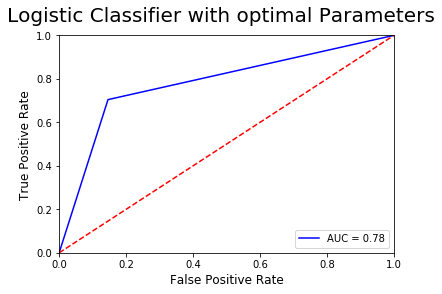

,Model,AUC ROC,F1
0,Logistic regression,0.778777,0.738798
1,Random Forest Classifier,0.751991,0.697971
2,ADA Boost Classifier,0.732362,0.669035
3,Extra Trees Classifier,0.756143,0.700885
4,Gradient Boosting Classifier,0.710140,0.614770
5,Decision Tree Classifier,0.715132,0.673136
6,SGD Classifier,0.790945,0.756842
7,Grid_SGD Classifier,0.782620,0.746285
8,Grid_Log Classifier,0.779297,0.739487


In [107]:
grid_log_prediction = grid_model_log.predict(X_test)
auc,f = roc(grid_log_prediction,'Logistic Classifier with optimal Parameters')

model_result = model_result.append({'Model':'Grid_Log Classifier','AUC ROC': auc,'F1':f}, ignore_index=True)
model_result